# HUMAN OR ROBOT

<h1> 1. Business Problem </h1>

<h2> 1.1 Description </h2>

&emsp;Human bidders on the site are becoming increasingly frustrated with their inability to win auctions vs. their software-controlled counterparts. As a result, usage from the site's core customer base is plummeting.  
&emsp;    In order to rebuild customer happiness, the site owners need to eliminate computer generated bidding from their auctions. Their attempt at building a model to identify these bids using behavioral data, including bid frequency over short periods of time, has proven insufficient.   
    &emsp;The goal is to identify online auction bids that are placed by "robots", helping the site owners easily flag these users for removal from their site to prevent unfair auction activity.

__Problem statement:__
    predict if an online bid is made by a machine or a human

<h2> 1.2 Sources/Useful Links</h2>

- source: https://www.kaggle.com/c/facebook-recruiting-iv-human-or-bot
<br><br>__Useful Links:__
- Discussion: https://www.kaggle.com/c/facebook-recruiting-iv-human-or-bot/discussion
- Blog 1: http://small-yellow-duck.github.io/auction.html
- Blog 2: https://blog.dataiku.com/2015/06/09/kaggle-feature-engineering
- Blog 3: https://www.analyticsvidhya.com/blog/2015/07/top-10-kaggle-fb-recruiting-competition/
- Interview: http://blog.kaggle.com/2015/06/19/facebook-iv-winners-interview-2nd-place-kiri-nicholaka-small-yellow-duck/

<h2>1.3 Real world/Business Objectives and Constraints </h2>

1. The cost mis classification is very high
2. You would want a probability of a pair of questions to be duplicates so that you can choose any threshold of choice.
3. predict as early as possible
4. Interpretability is partially important.

<h1>2. Machine Learning Probelm </h1>

<h2> 2.1 Data </h2>

<h3> 2.1.1 Data Overview </h3>

https://www.kaggle.com/c/facebook-recruiting-iv-human-or-bot/data

__Data Files:__
- train.csv - the training set from the bidder dataset  
- test.csv - the test set from the bidder dataset  
- bids.csv - the bid dataset 
<p> we will use only train.csv, as there is no ground truth present in test.csv</p>

____For the bidder dataset:____

__bidder_id__ – Unique identifier of a bidder.  
__payment_account__ – Payment account associated with a bidder. These are obfuscated to protect privacy.   
__address__ – Mailing address of a bidder. These are obfuscated to protect privacy.   
__outcome__ – Label of a bidder indicating whether or not it is a robot. Value 1.0 indicates a robot, where value 0.0 indicates human.    
The outcome was half hand labeled, half stats-based. There are two types of "bots" with different levels of proof:

1. Bidders who are identified as bots/fraudulent with clear proof. Their accounts were banned by the auction site.  

2. Bidder who may have just started their business/clicks or their stats exceed from system wide average. There are no clear proof that they are bots.   



____For the bid dataset:____

__bid_id__ - unique id for this bid  
__bidder_id__ – Unique identifier of a bidder (same as the bidder_id used in train.csv and test.csv)  
__auction__ – Unique identifier of an auction  
__merchandise__ –  The category of the auction site campaign, which means the bidder might come to this site by way of searching for "home goods" but ended up bidding for "sporting goods" - and that leads to this field being "home goods". This categorical field could be a search term, or online advertisement.   
__device__ – Phone model of a visitor  
__time__ - Time that the bid is made (transformed to protect privacy).  
__country__ - The country that the IP belongs to  
__ip__ – IP address of a bidder (obfuscated to protect privacy).  
__url__ - url where the bidder was referred from (obfuscated to protect privacy).   

<h3> 2.1.2 Example Data point </h3>

__Bidder Data:__ 

 
|bidder_id|payment_account|address|outcome|
|:-------:|:-------------:|:------:|:-----:|
|91a3c57b13234af24875c56fb7e2b2f4rb56a|a3d2de7675556553a5f08e4c88d2c228754av|a3d2de7675556553a5f08e4c88d2c228vt0u4|0.0|

__Bid Data:__ 

|bid_id|bidder_id|auction|merachandise|device|time|country|ip|url|
|:----:|:-------:|:-----:|:----------:|:----:|:---:|:----:|:----:|
|0|8dac2b259fd1c6d1120e519fb1ac14fbqvax8|ewmzr|jewelry|phone0|9759243157894736|us|69.166.231.58|vasstdc27m7nks3|

<h2> 2.2 Mapping the real world problem to an ML problem </h2>

<h3> 2.2.1 Type of Machine Leaning Problem </h3>

<p>It is binary classification problem. predict if an online bid is made by a machine or a human</p>

<h3> 2.2.2 Performance Metric </h3>

Metrics:
* ROC curve
* log loss

<h1>3. Exploratory Data Analysis </h1>

In [222]:
#loding requires libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
import warnings
import os
import pickle

warnings.filterwarnings('ignore')

In [223]:
#loading bidder data from train
bidder_data=pd.read_csv('train.csv')

In [224]:
#trying to see some data
bidder_data.head()

,bidder_id,payment_account,address,outcome
0,91a3c57b13234af24875c56fb7e2b2f4rb56a,a3d2de7675556553a5f08e4c88d2c228754av,a3d2de7675556553a5f08e4c88d2c228vt0u4,0.0
1,624f258b49e77713fc34034560f93fb3hu3jo,a3d2de7675556553a5f08e4c88d2c228v1sga,ae87054e5a97a8f840a3991d12611fdcrfbq3,0.0
2,1c5f4fc669099bfbfac515cd26997bd12ruaj,a3d2de7675556553a5f08e4c88d2c2280cybl,92520288b50f03907041887884ba49c0cl0pd,0.0
3,4bee9aba2abda51bf43d639013d6efe12iycd,51d80e233f7b6a7dfdee484a3c120f3b2ita8,4cb9717c8ad7e88a9a284989dd79b98dbevyi,0.0
4,4ab12bc61c82ddd9c2d65e60555808acqgos1,a3d2de7675556553a5f08e4c88d2c22857ddh,2a96c3ce94b3be921e0296097b88b56a7x1ji,0.0


In [225]:
print('Data points in Train:',bidder_data.shape[0])

Data points in Train: 2013


In [293]:
print('Number of Robots:',len(bidder_data[bidder_data.outcome==1]))
print('Number of Humans:',len(bidder_data[bidder_data.outcome==0]))

Number of Robots: 103
Number of Humans: 1880


__Imbalanced data__

In [226]:
#loading bid data
bid_data=pd.read_csv('bids.csv')

In [227]:
#trying to see some data
bid_data.head()

,bid_id,bidder_id,auction,merchandise,device,time,country,ip,url
0,0,8dac2b259fd1c6d1120e519fb1ac14fbqvax8,ewmzr,jewelry,phone0,9759243157894736,us,69.166.231.58,vasstdc27m7nks3
1,1,668d393e858e8126275433046bbd35c6tywop,aeqok,furniture,phone1,9759243157894736,in,50.201.125.84,jmqlhflrzwuay9c
2,2,aa5f360084278b35d746fa6af3a7a1a5ra3xe,wa00e,home goods,phone2,9759243157894736,py,112.54.208.157,vasstdc27m7nks3
3,3,3939ac3ef7d472a59a9c5f893dd3e39fh9ofi,jefix,jewelry,phone4,9759243157894736,in,18.99.175.133,vasstdc27m7nks3
4,4,8393c48eaf4b8fa96886edc7cf27b372dsibi,jefix,jewelry,phone5,9759243157894736,in,145.138.5.37,vasstdc27m7nks3


In [228]:
#number of data points
print('Number of bids:',bid_data.shape[0])

Number of bids: 7656334


In [229]:
#sorting by inplace along the time axis 
bid_data.sort_values('time',ascending=True,inplace=True)

<h3> Pre process bidder data</h3>

__As Payment account and address column values are hashed values, stripping last five characteristics__

In [230]:
bidder_data.payment_account=bidder_data.payment_account.apply(lambda x:x[:-5])
bidder_data.address=bidder_data.address.apply(lambda x:x[:-5])

__Featurizing Address column__

In [231]:
#https://github.com/small-yellow-duck/facebook_auction/blob/master/fba-sub9.py
print('There are ',bidder_data['address'].nunique(),' unique addresses among ',bidder_data.shape[0],' total addresses')

There are  1418  unique addresses among  2013  total addresses


In [232]:
temp=bidder_data.groupby('address').size().reset_index().sort_values(0,ascending=False)

In [233]:
temp = temp.rename(columns = {0:'address_count'})

In [234]:
#some addresses are very frequent, more addresses are infrequent
np.percentile(temp['address_count'],90)

1.0

__nearly 92% of addresses are unique__

In [235]:
np.percentile(temp['address_count'],97)

2.0

__Address count between 2 and 5 (inclusive) encoded as "Infrequent address"__  
__Address count 1 is encoded as rare address__

In [236]:
max_relevant = 6
infrequent_addresses=temp[temp.address_count >= 2][temp.address_count < max_relevant].address.values
rare_addresses=temp[temp.address_count<2].address.values
bidder_data['address'].loc[bidder_data['address'].isin(rare_addresses)]='rare_address'
bidder_data['address'].loc[bidder_data.address.isin(infrequent_addresses)] = 'infrequent_address'
temp=pd.get_dummies(bidder_data[['address']])
#concating the one hot encoded features to the bidder_data
bidder_data=pd.concat([bidder_data,temp],axis=1)

__Featurizing payment_account column__

In [237]:
print('There are ',bidder_data['payment_account'].nunique(),' unique addresses among ',bidder_data.shape[0],' total addresses')

There are  840  unique addresses among  2013  total addresses


In [238]:
temp=bidder_data.groupby('payment_account').size().reset_index().sort_values(0,ascending=False)

In [239]:
temp = temp.rename(columns = {0:'payment_account_count'})

<p>when we perform one hot encoding over Address column, it will generate 840 features</p>

In [240]:
np.percentile(temp['payment_account_count'],97)

2.0

__Encoding payment_account with count 1 as rare payment accounts to reduce the features__  
__Encoding pament_account with count between 2 and 5 (inclusive) as infrequent accounts__

In [241]:
infrequent_payment_account = temp[temp.payment_account_count >= 2][temp.payment_account_count < max_relevant].payment_account.values
rare_account=temp[temp.payment_account_count<2].payment_account.values
bidder_data['payment_account'].loc[bidder_data.payment_account.isin(rare_account)]='rare_account'
bidder_data['payment_account'].loc[bidder_data.payment_account.isin(infrequent_payment_account)] = 'infrequent_account'
temp=pd.get_dummies(bidder_data[['payment_account']])
#concating one hot encoded features
bidder_data=pd.concat([bidder_data,temp],axis=1)
#drop 'address' and 'payment account' columns from bidder_data
bidder_data=bidder_data.drop('address',axis=1)
bidder_data=bidder_data.drop('payment_account',axis=1)

<h2> 4  Feature Extraction </h3>

Basically when we analyze what makes distinction beteen robots and humans is:  
__* Robots can participate in more auctions__  
__* Number bids robot can make is more__  
__* Robots can bid faster__  

<h3> 4.1 Number of bids</h3>

In [277]:
temp=bid_data.groupby('bidder_id').size().reset_index().sort_values(0,ascending=False)
temp=temp.rename(columns={0:'num_bids'})
bidder_data=bidder_data.merge(temp,on='bidder_id',how='inner')

<h3>4.2 Number of auctions participated</h3>

In [242]:
temp=bid_data[['bidder_id','auction']]
temp=temp.groupby(['bidder_id']).auction.nunique().reset_index().sort_values('auction',ascending=False)
temp=temp.rename(columns={'auction':'unique_auctions_participated'})
#Adding feature 'unique_auctions_participated' to bidder_data
bidder_data=bidder_data.merge(temp,on='bidder_id',how='inner')
bidder_data=bidder_data.fillna(0)

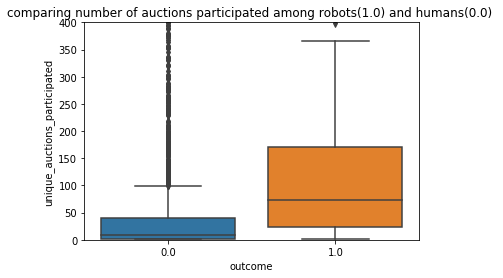

In [244]:
sns.boxplot(x='outcome',y='unique_auctions_participated',data=bidder_data)
plt.title('comparing number of auctions participated among robots(1.0) and humans(0.0) ')
plt.ylim(0,400)
plt.show()

<h3>4.3 Number of bids per auction</h3>

In [245]:
temp=bid_data.groupby(['bidder_id','auction']).size().reset_index().sort_values(0,ascending=False)
temp=temp.rename(columns={0:'bids_per_auction'})
temp=temp.groupby('bidder_id').bids_per_auction.median().sort_values(ascending=False).reset_index()
temp=temp.rename(columns={'bids_per_auction':'bids_per_auction_median'})
#Adding feature 'bids_per_auction_median'
bidder_data=bidder_data.merge(temp,on='bidder_id',how='inner')
bidder_data=bidder_data.fillna(0)

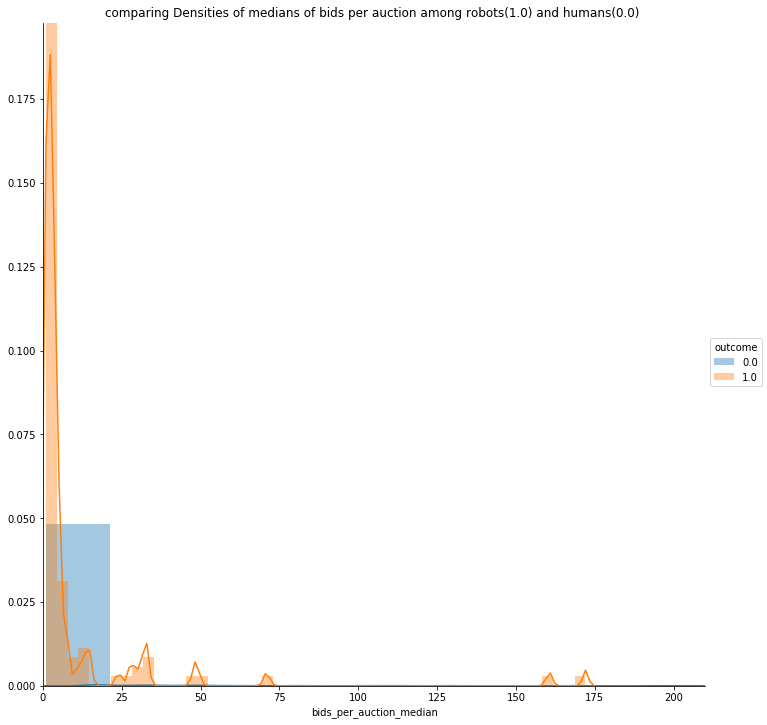

In [246]:
sns.FacetGrid(bidder_data, hue="outcome", size=10) \
   .map(sns.distplot, "bids_per_auction_median") \
   .add_legend();
plt.title('comparing Densities of medians of bids per auction among robots(1.0) and humans(0.0) ')
plt.xlim(0,210)
plt.show();

__Every where in the plot, Density corresponding to robot is dominating which indicates importance of this feature__

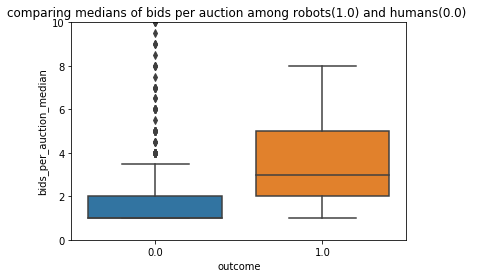

In [247]:
sns.boxplot(x='outcome',y='bids_per_auction_median',data=bidder_data)
plt.title('comparing medians of bids per auction among robots(1.0) and humans(0.0) ')
plt.ylim(0,10)
plt.show()

<h3>4.4 Number of bids per device</h3>

In [248]:
temp=bid_data.groupby(['bidder_id','device']).size().reset_index().sort_values(0,ascending=False)
temp=temp.rename(columns={0:'bids_per_device'})
temp=temp.groupby('bidder_id').bids_per_device.median().sort_values(ascending=False).reset_index()
temp=temp.rename(columns={'bids_per_device':'bids_per_device_median'})
#Adding Feature 'bids_per_device_median'
bidder_data=bidder_data.merge(temp,on='bidder_id',how='inner')
bidder_data=bidder_data.fillna(0)

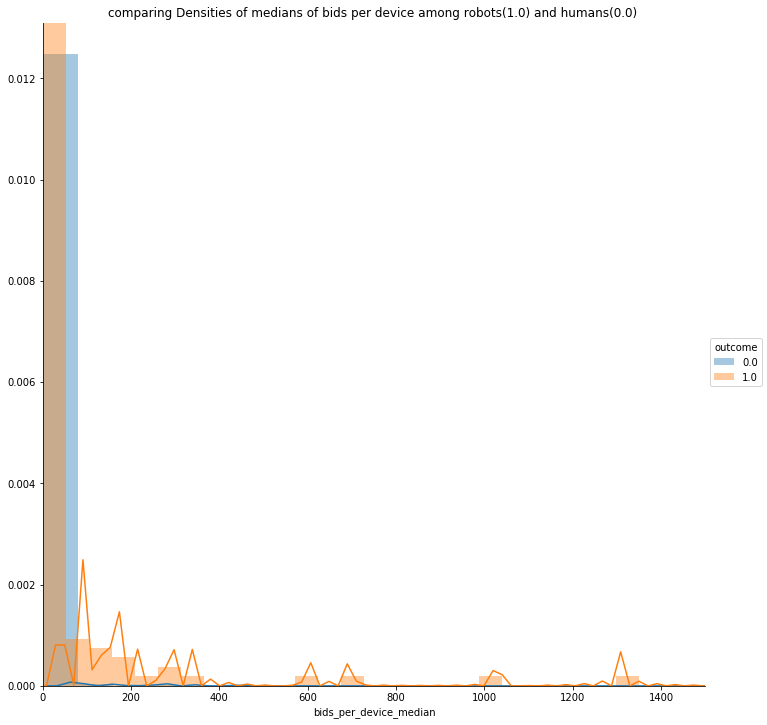

In [249]:
sns.FacetGrid(bidder_data, hue="outcome", size=10) \
   .map(sns.distplot, "bids_per_device_median") \
   .add_legend();
plt.title('comparing Densities of medians of bids per device among robots(1.0) and humans(0.0) ')
plt.xlim(0,1500)
plt.show();

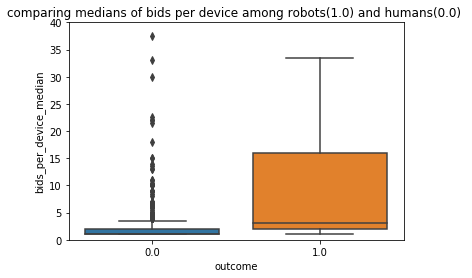

In [250]:
sns.boxplot(x='outcome',y='bids_per_device_median',data=bidder_data)
plt.title('comparing medians of bids per device among robots(1.0) and humans(0.0) ')
plt.ylim(0,40)
plt.show()

<h3>4.5 Number of bids per IP</h3>

In [251]:
temp=bid_data.groupby(['bidder_id','ip']).size().reset_index().sort_values(0,ascending=False)
temp=temp.rename(columns={0:'bids_per_ip'})
temp=temp.groupby('bidder_id').bids_per_ip.median().sort_values(ascending=False).reset_index()
temp=temp.rename(columns={'bids_per_ip':'bids_per_ip_median'})
#Adding feature 'bids_per_ip_median'
bidder_data=bidder_data.merge(temp,on='bidder_id',how='inner')
bidder_data=bidder_data.fillna(0)

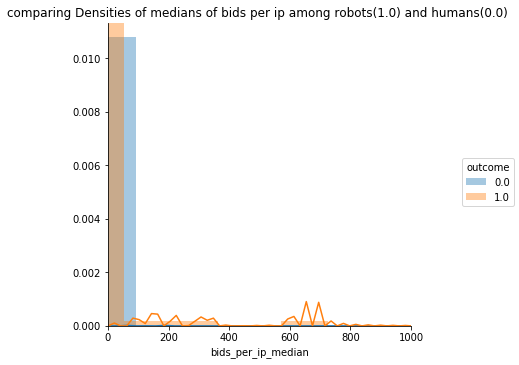

In [252]:
sns.FacetGrid(bidder_data, hue="outcome", size=5) \
   .map(sns.distplot, "bids_per_ip_median") \
   .add_legend();
plt.title('comparing Densities of medians of bids per ip among robots(1.0) and humans(0.0) ')
plt.xlim(0,1000)
plt.show();

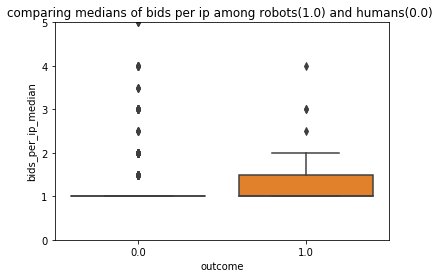

In [253]:
sns.boxplot(x='outcome',y='bids_per_ip_median',data=bidder_data)
plt.title('comparing medians of bids per ip among robots(1.0) and humans(0.0) ')
plt.ylim(0,5)
plt.show()

<h3>4.6 Number of bids per country</h3>

In [254]:
temp=bid_data.groupby(['bidder_id','country']).size().reset_index().sort_values(0,ascending=False)
temp=temp.rename(columns={0:'bids_per_country'})
temp=temp.groupby('bidder_id').bids_per_country.median().sort_values(ascending=False).reset_index()
temp=temp.rename(columns={'bids_per_country':'bids_per_country_median'})
#Adding feature 'bids_per_country_median'
bidder_data=bidder_data.merge(temp,on='bidder_id',how='inner')
bidder_data=bidder_data.fillna(0)

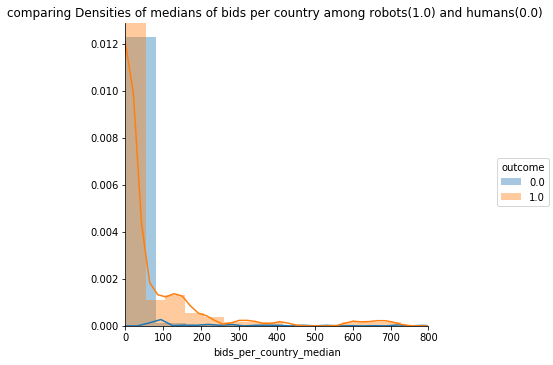

In [255]:
sns.FacetGrid(bidder_data, hue="outcome", size=5) \
   .map(sns.distplot, "bids_per_country_median") \
   .add_legend();
plt.title('comparing Densities of medians of bids per country among robots(1.0) and humans(0.0) ')
plt.xlim(0,800)
plt.show();

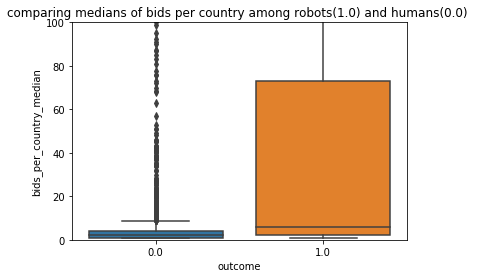

In [256]:
sns.boxplot(x='outcome',y='bids_per_country_median',data=bidder_data)
plt.title('comparing medians of bids per country among robots(1.0) and humans(0.0) ')
plt.ylim(0,100)
plt.show()

<h3>4.7 Number Ips used by bidder</h3>

In [257]:
temp=bid_data[['bidder_id','ip']]
temp=temp.groupby(['bidder_id']).ip.nunique().reset_index().sort_values('ip',ascending=False)
temp=temp.rename(columns={'ip':'unique_ips_used'})
#Adding feature unique_ips_used
bidder_data=bidder_data.merge(temp,on='bidder_id',how='inner')
bidder_data=bidder_data.fillna(0)

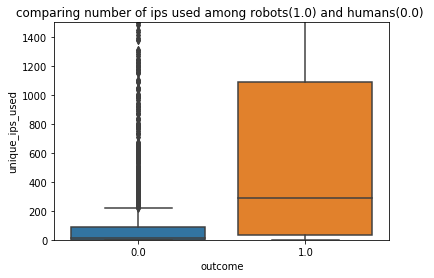

In [258]:
sns.boxplot(x='outcome',y='unique_ips_used',data=bidder_data)
plt.title('comparing number of ips used among robots(1.0) and humans(0.0) ')
plt.ylim(0,1500)
plt.show()

<h3>4.8 Number devices used by bidder</h3>

In [259]:
temp=bid_data[['bidder_id','device']]
temp=temp.groupby(['bidder_id']).device.nunique().reset_index().sort_values('device',ascending=False)
temp=temp.rename(columns={'device':'unique_devices_used'})
#Adding feature 'unique_devices_used'
bidder_data=bidder_data.merge(temp,on='bidder_id',how='inner')
bidder_data=bidder_data.fillna(0)

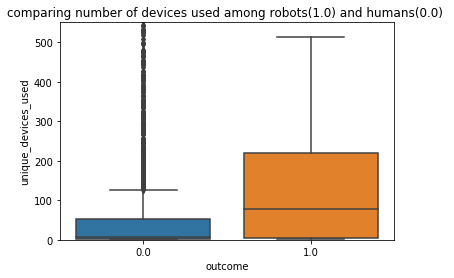

In [260]:
sns.boxplot(x='outcome',y='unique_devices_used',data=bidder_data)
plt.title('comparing number of devices used among robots(1.0) and humans(0.0) ')
plt.ylim(0,550)
plt.show()

<h3>4.9 Features related to Response time</h3>

__Response time is the time between successive bids per each bidder irrespective of auctions participating __

In [270]:
temp=pd.DataFrame(bidder_data['bidder_id'])

In [271]:
resp_min=[]   #min's of response time
resp_mean=[]  #mean's of response time
resp_median=[] #median's of response time

In [272]:
if os.path.isfile('resp_min.pickle') and os.path.isfile('resp_mean.pickle') and os.path.isfile('resp_median.pickle'):
    pickle_in=open('resp_min.pickle','rb')
    resp_min=pickle.load(pickle_in)
    pickle_in.close()
    pickle_in=open('resp_mean.pickle','rb')
    resp_mean=pickle.load(pickle_in)
    pickle_in.close()
    pickle_in=open('resp_median.pickle','rb')
    resp_median=pickle.load(pickle_in)
    pickle_in.close()
else:
    bidders=bidder_data['bidder_id']
    for bidder in bidders:
        l=bid_data[bid_data.bidder_id==bidder]
        if(l.shape[0]==1):
            resp_min.append(float(0))
            resp_mean.append(float(0))
            resp_median.append(float(0))
        continue
        l.sort_values('time',ascending=True,inplace=True)
        time=[]
        diff=[] #stores the consecutive differences in time
        i=0
        for i in range(l.shape[0]):
            temp_1=l.iloc[i]
            time.append(float(temp_1['time']))
            if(i==l.shape[0]-1):
                continue
            else:
                temp_2=l.iloc[i+1]
            temp_1=temp_1['time']
            temp_2=temp_2['time']
            diff.append(float(temp_2-temp_1))
            i=i+1
        l=pd.Series(diff)
        resp_min.append(float(l.min()))
        resp_mean.append(float(l.mean()))
        resp_median.append(float(l.median()))
        
        pickle_out=open('resp_min.pickle','rw')
        resp_min=pickle.dump(pickle_out)
        pickle_out.close()
        
        pickle_out=open('resp_mean.pickle','rw')
        resp_min=pickle.dump(pickle_out)
        pickle_out.close()
        
        pickle_out=open('resp_median.pickle','rw')
        resp_median=pickle.dump(pickle_out)
        pickle_out.close()

In [273]:
resp_min=pd.Series(resp_min)
resp_mean=pd.Series(resp_mean)
resp_median=pd.Series(resp_median)
temp.insert(loc=1,column='response_min',value=resp_min)
temp.insert(loc=2,column='response_mean',value=resp_mean)
temp.insert(loc=3,column='response_median',value=resp_median)

In [274]:
bidder_data=bidder_data.merge(temp,on='bidder_id',how='inner')
bidder_data=bidder_data.fillna(-1)

In [275]:
bidder_data.sort_values('response_median',ascending=True,inplace=True)

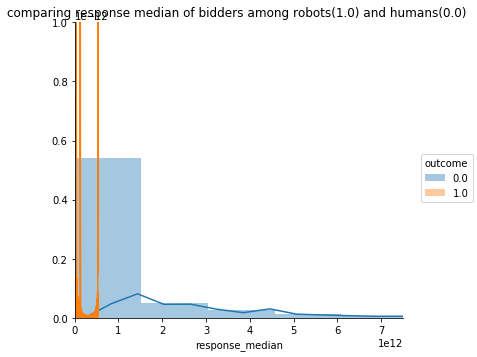

In [295]:
sns.FacetGrid(bidder_data, hue="outcome", size=5) \
   .map(sns.distplot, "response_median") \
   .add_legend();
plt.title('comparing response median of bidders among robots(1.0) and humans(0.0) ')
plt.xlim(0,7.5e12)
plt.ylim(0,1e-12)
plt.show();

<h3>4.10 Merchandise participated by bidder</h3>

In [278]:
temp=bid_data.groupby('bidder_id').merchandise.first().reset_index().rename(columns={0:'merchandise'})
bidder_data=bidder_data.merge(temp,on='bidder_id',how='inner')
#http://queirozf.com/entries/one-hot-encoding-a-feature-on-a-pandas-dataframe-an-example
bidder_data=pd.concat([bidder_data,pd.get_dummies(bidder_data['merchandise'], prefix='merchandise')],axis=1).drop(['merchandise'],axis=1)

<h3>4.11 Time between last and first auction</h3>

In [281]:
temp=pd.DataFrame(bidder_data['bidder_id'])

In [282]:
duration=[]   #stores time differences
if os.path.isfile('resp_min.pickle'):
    pickle_in=open('duration.pickle','rb')
    duration=pickle.load(pickle_in)
    pickle_in.close()
else:
    bidders=bidder_data.bidder_id.values
    for bidder in bidders:
        l=bid_data[bid_data.bidder_id==bidder]
        if(l.shape[0]==1):
            duration.append(float(0))
            continue
        l.sort_values('time',ascending=True,inplace=True)
        temp_1=l.iloc[0]
        if(l.shape[0]==1):
            continue
        else:
            temp_2=l.iloc[l.shape[0]-1]
        temp_1=temp_1['time']
        temp_2=temp_2['time']
        duration.append(float(temp_2-temp_1)) 
        
        pickle_out=open('duration.pickle','rw')
        duration=pickle.load(pickle_out)
        pickle_out.close()

In [283]:
duration=pd.Series(duration)
temp.insert(loc=1,column='duration',value=duration)
bidder_data=bidder_data.merge(temp,on='bidder_id',how='inner')
bidder_data=bidder_data.fillna(-1)

<h2>5 Machine Learning model</h2>

<h3>5.1 Logistic Regression</h3>

In [417]:
X=bidder_data.drop('outcome',axis=1)
Y=bidder_data['outcome'].values
X.drop('bidder_id',axis=1,inplace=True)
X=(X-X.mean())/X.std()

In [418]:
#Divide data in to train and test
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,stratify=Y,test_size=0.2)

In [419]:
from sklearn.linear_model import LogisticRegression
from sklearn.grid_search import GridSearchCV
tuned_params=[{'C':[10**-4,10**-3,10**-2,10**-1,10**0,10**1,10**2,10**3,10**4]}]

Logistic_grid=GridSearchCV(LogisticRegression(n_jobs=-1),tuned_params,cv=10,scoring='accuracy')

In [420]:
Logistic_grid.fit(X_train,Y_train)
print(Logistic_grid.best_estimator_)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


In [421]:
from sklearn.metrics import accuracy_score
Y_hat=Logistic_grid.predict(X_test)
print('accuracy:',accuracy_score(Y_test,Y_hat))

accuracy: 0.9420654911838791


-------------------- Confusion matrix --------------------


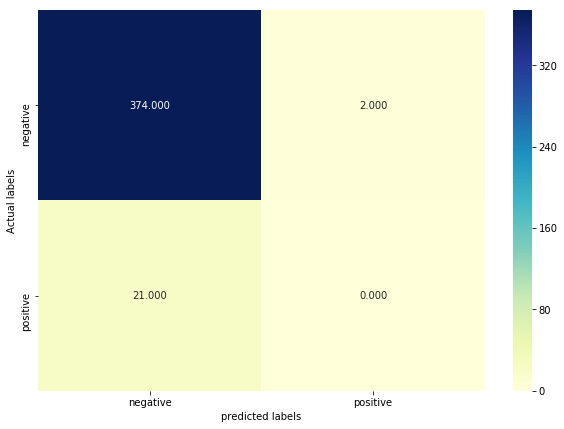

In [422]:
cm=confusion_matrix(Y_test,Y_hat)
labels=['negative','positive']
x=plt.figure(figsize=(10,7))
print("-"*20, "Confusion matrix", "-"*20)
sns.heatmap(cm,annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
plt.xlabel('predicted labels')
plt.ylabel('Actual labels')
plt.show()

In [423]:
from sklearn.metrics import roc_auc_score
print("AUC - ROC : ", roc_auc_score(Y_test,Y_hat))

AUC - ROC :  0.4973404255319149


In [424]:
TN=cm[0][0]
FP=cm[0][1]
N=TN+FP
print("True Negative Rate(TNR):",(TN/N)*100)
print("False Positive Rate(FPR)",(FP/N)*100)
FN=cm[1][0]
TP=cm[1][1]
P=FN+TP
print("False Negative Rate(FNR):",(FN/P)*100)
print("True positive Rate(TPR):",(TP/P)*100)
#precision: Of all the points predicted as positive how many of them actually positive
Pr=(TP/(TP+FP))*100
print("Precision:",Pr)
Re=(TP/P)*100
print("Recall(TPR):",Re)
F1=2*(Pr*Re)/(Pr+Re)
print("F1 score:",F1)

True Negative Rate(TNR): 99.46808510638297
False Positive Rate(FPR) 0.5319148936170213
False Negative Rate(FNR): 100.0
True positive Rate(TPR): 0.0
Precision: 0.0
Recall(TPR): 0.0
F1 score: nan


__Not performing well __

<h3>5.2 Decision Tree</h3>

In [425]:
from sklearn.tree import DecisionTreeClassifier
depth=[2,3,4,5,6,7,8,9,10,15,20,25,30]
cv_scores=[]
for d in depth:
    clf=DecisionTreeClassifier(max_depth=d)
    scores=cross_val_score(clf,X_train,Y_train,cv=10,scoring='accuracy')
    cv_scores.append(scores.mean())

optimal depth of Tree is 4


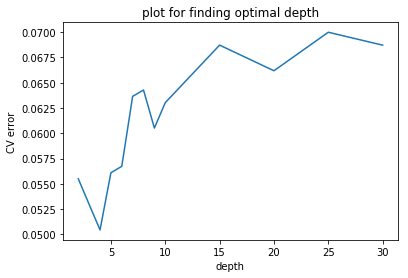

In [426]:
import matplotlib.pylab as plt
MSE=[1-x for x in cv_scores]
min_index=MSE.index(min(MSE))
optimal_depth=depth[min_index]
print("optimal depth of Tree is %d"% optimal_depth)

plt.plot(depth,MSE)
plt.title('plot for finding optimal depth')
plt.xlabel('depth')
plt.ylabel('CV error')
plt.show()

In [427]:
clf=DecisionTreeClassifier(max_depth=optimal_depth)
clf.fit(X_train,Y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [428]:
pred=clf.predict(X_test)
print('accuracy:',accuracy_score(Y_test,pred))

accuracy: 0.9420654911838791


-------------------- Confusion matrix --------------------


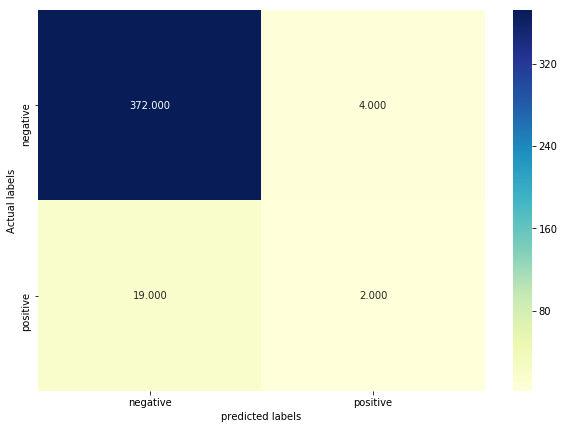

In [429]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
cm=confusion_matrix(Y_test,pred)
labels=['negative','positive']
x=plt.figure(figsize=(10,7))
print("-"*20, "Confusion matrix", "-"*20)
sns.heatmap(cm,annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
plt.xlabel('predicted labels')
plt.ylabel('Actual labels')
plt.show()

In [430]:
print("AUC - ROC : ", roc_auc_score(Y_test,pred))

AUC - ROC :  0.5422998986828774


In [431]:
TN=cm[0][0]
FP=cm[0][1]
N=TN+FP
print("True Negative Rate(TNR):",(TN/N)*100)
print("False Positive Rate(FPR)",(FP/N)*100)
FN=cm[1][0]
TP=cm[1][1]
P=FN+TP
print("False Negative Rate(FNR):",(FN/P)*100)
print("True positive Rate(TPR):",(TP/P)*100)
#precision: Of all the points predicted as positive how many of them actually positive
Pr=(TP/(TP+FP))*100
print("Precision:",Pr)
Re=(TP/P)*100
print("Recall(TPR):",Re)
F1=2*(Pr*Re)/(Pr+Re)
print("F1 score:",F1)

True Negative Rate(TNR): 98.93617021276596
False Positive Rate(FPR) 1.0638297872340425
False Negative Rate(FNR): 90.47619047619048
True positive Rate(TPR): 9.523809523809524
Precision: 33.33333333333333
Recall(TPR): 9.523809523809524
F1 score: 14.814814814814813


<h3> 5.3 Random Forest Classifier</h3>

In [544]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
c=[2,5,10,15,20,25,30,35,40,45,50,55,60,75,100,125,150,175,200,500,1000]
cv_scores=[]
for d in c:
    clf=RandomForestClassifier(n_estimators=d,n_jobs=-1)
    scores=cross_val_score(clf,X_train,Y_train,cv=10,scoring='accuracy')
    cv_scores.append(scores.mean())

optimal number of classifiers in Random Forest is 75


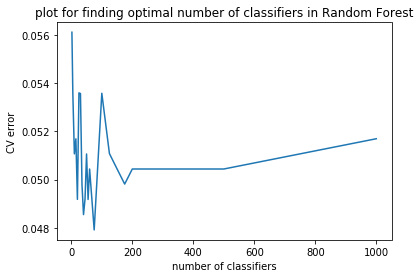

In [545]:
import matplotlib.pylab as plt
MSE=[1-x for x in cv_scores]
min_index=MSE.index(min(MSE))
optimal_c=c[min_index]
print("optimal number of classifiers in Random Forest is %d"% optimal_c)

plt.plot(c,MSE)
plt.title('plot for finding optimal number of classifiers in Random Forest')
plt.xlabel('number of classifiers')
plt.ylabel('CV error')
plt.show()

In [546]:
RF_clf=RandomForestClassifier(n_estimators=optimal_c,oob_score=True,n_jobs=-1)
RF_clf.fit(X_train,Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=75, n_jobs=-1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

In [547]:
pred=RF_clf.predict(X_test)
print(accuracy_score(Y_test,pred))

0.9596977329974811


-------------------- Confusion matrix --------------------


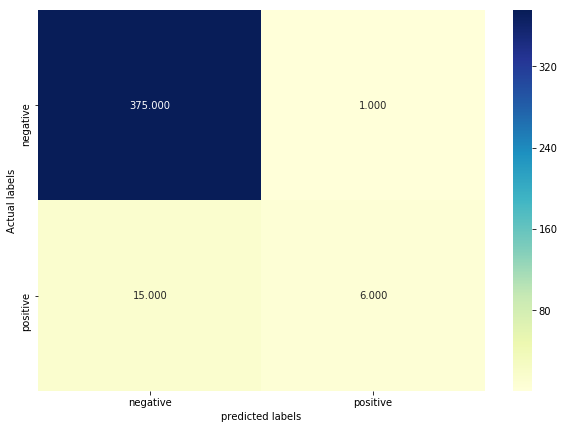

In [548]:
cm=confusion_matrix(Y_test,pred)
labels=['negative','positive']
x=plt.figure(figsize=(10,7))
print("-"*20, "Confusion matrix", "-"*20)
sns.heatmap(cm,annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
plt.xlabel('predicted labels')
plt.ylabel('Actual labels')
plt.show()

In [549]:
from sklearn.metrics import roc_auc_score
print("AUC - ROC : ", roc_auc_score(Y_test,pred))

AUC - ROC :  0.6415273556231003


In [550]:
TN=cm[0][0]
FP=cm[0][1]
N=TN+FP
print("True Negative Rate(TNR):",(TN/N)*100)
print("False Positive Rate(FPR)",(FP/N)*100)
FN=cm[1][0]
TP=cm[1][1]
P=FN+TP
print("False Negative Rate(FNR):",(FN/P)*100)
print("True positive Rate(TPR):",(TP/P)*100)
#precision: Of all the points predicted as positive how many of them actually positive
Pr=(TP/(TP+FP))*100
print("Precision:",Pr)
Re=(TP/P)*100
print("Recall(TPR):",Re)
F1=2*(Pr*Re)/(Pr+Re)
print("F1 score:",F1)

True Negative Rate(TNR): 99.7340425531915
False Positive Rate(FPR) 0.26595744680851063
False Negative Rate(FNR): 71.42857142857143
True positive Rate(TPR): 28.57142857142857
Precision: 85.71428571428571
Recall(TPR): 28.57142857142857
F1 score: 42.857142857142854


__Observations:__

| model         | Train metric|  score(Test)      |      
|:-------------:|:---------------------------:|:-------:|
|Logistic Regression (C=0.1)        |AUC-ROC        |  0.4973     |     
|Decision Tree  (depth=4)       |AUC-ROC         | 0.5423    | 
|Random Forest (n_estimators=75)  |AUC-ROC         |   0.6415     |

__Random Forest is performing better__